# Vanessa Schreck & Lisa Mattrisch

In [1]:
import torch
torch.__version__

'0.3.0b0+591e73e'

# Assignment 1

Fill in the code and then print to PDF to send for marking.

## A first look at PyTorch


We will now take a look at a first concrete example of a neural network, which makes use of the Python library PyTorch to learn to classify fashion articles. Unless you already have experience with PyTorch or similar libraries, you will not understand everything about this first example right away. You probably haven't even installed Pytorch yet. Don't worry, that is perfectly fine. We will do all that below.

The problem we are trying to solve here is to classify grayscale images of fashion articles (28 pixels by 28 pixels), into their 10 categories. The dataset we will use is the Fashion-MNIST dataset, a dropin replacement of MNIST which is a classic dataset in the machine learning community, which has been around for almost as long as the field itself and has been very intensively studied. It's a set of 60,000 training images, plus 10,000 test images. You can think of "solving" Fashion-MNIST or MNIST as the "Hello World" of deep learning --- it's what you do to verify that your algorithms are working as expected. As you become a machine learning practitioner, you will see MNIST come up over and over again, in scientific papers, blog posts, and so on.

The Fashion-MNIST and MNIST datasets comes as standard datasets in PyTorch's `torchvision` library, as subclasses of `torch.utils.data.Dataset` which makes it convinent to use as we will see.

Our images are encoded as `PIL.Image.Image` objects, and the labels are simply an array of integers, ranging from 0 to 9.  There is a one-to-one correspondence between the images and the labels.

Before training, we will transform our data by first converting it to a `Tensor` and then  normalizing it so that all image values have mean 0.5 and standard deviation of 1, by composing these operations as `transforms` function to the datasets:

In [2]:
from torchvision import datasets, transforms

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

train_dataset = datasets.FashionMNIST('data', transform=trans, train=True, download=True)
test_dataset = datasets.FashionMNIST('data', transform=trans, train=False, download=True)

Processing...
Done!


`train_dataset` forms the "training set", the data that the model will learn from. The model will then be tested on the "test set", `test_dataset`. 

Let's have a look at the training data:

In [3]:
len(train_dataset)

60000

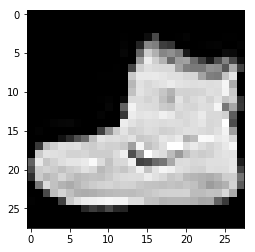

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(train_dataset.train_data[0], cmap='gray')

In [23]:
train_dataset.train_labels[0]

9

Let's have a look at the test data:

In [6]:
len(test_dataset)

10000

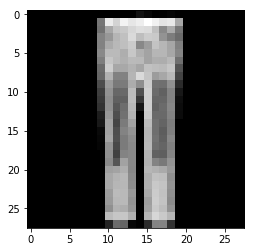

In [7]:
plt.imshow(test_dataset.test_data[15], cmap='gray')

In [8]:
test_dataset.test_labels[15]

1

Our workflow will be as follow: first we will present our neural network with the training data, `train_dataset` via the `DataLoader` iterator. The network will then learn to associate images and labels. Finally, we will ask the network to produce predictions for `test_dataset`, and we will verify if these predictions match the test labels.

Let's build our network --- again, remember that you aren't supposed to understand everything about this example just yet.

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)

In [46]:
model = Net()
if torch.cuda.is_available():
    model.cuda()

The core building block of neural networks is the "layer", a data-processing module which you can conceive as a "filter" for data. Some data comes in, and comes out in a more useful form. Precisely, layers extract _representations_ out of the data fed into them --- hopefully  representations that are more meaningful for the problem at hand. Most of deep learning really consists of chaining together simple layers  which will implement a form of progressive "data distillation". A deep learning model is like a sieve for data processing, made of a  succession of increasingly refined data filters --- the "layers".

Here our network consists of a sequence of two `Linear` layers, which are densely-connected (also called "fully-connected") neural layers.  The output (and last) layer is a 10-way "softmax" layer, which means it will return an array of 10 probability scores (summing to 1). Each  score will be the probability that the current article image belongs to one of our 10 classes.

To make our network ready for training, we need to pick three more things:

* An optimizer: this is the mechanism through which the network will update itself based on the data it sees and its loss function.
* A loss function: the is how the network will be able to measure how good a job it is doing on its training data, and thus how it will be  able to steer itself in the right direction.
* Metrics to monitor during training and testing. Here we will only care about accuracy (the fraction of the images that were correctly classified).

The exact purpose of the loss function and the optimizer will be made clear throughout the next lectures and homeworks. Lets start with the optimizer:

In [47]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [48]:
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=128, 
                                           shuffle=True,
                                           **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=128,
                                          shuffle=False,
                                          **kwargs)

We are now ready to train our network, meaning, we "fit" the model to its training data, which in PyTorch is done via a `train()`  helper which typically contains the loss we wish to minimize and looks like this: 

In [49]:
from torch.autograd import Variable

def train(epoch):
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()
        
        output = model(data)
        
        loss = F.nll_loss(output, target)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

The quantity being displayed during training in the above helper is: the "loss" of the network over the training data. Let us write a `test()` helper which will print out the accuracy metric of the network over the test data:

In [50]:
def test():
    model.eval()
    
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

Now let us  train the network for 5 epochs and print the test set accuracy at the end of each epoch:

In [51]:
for epoch in range(1, 5 + 1):
    train(epoch)
    test()

C:\Users\LMatt\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.252408
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.137462
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.032031
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.977940
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.799382
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.714559
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.553766
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.510972
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.429167
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.357034
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.318768
Train Epoch: 1 [14080/60000 (23%)]	Loss: 1.209375
Train Epoch: 1 [15360/60000 (26%)]	Loss: 1.070992
Train Epoch: 1 [16640/60000 (28%)]	Loss: 1.162737
Train Epoch: 1 [17920/60000 (30%)]	Loss: 1.062681
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.030166
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.991245
Train Epoch: 1 [21760/60000 (36%)]	Loss: 1.041260
Train Epoch: 1 [23040/60000 (38%)]	Loss: 1.016068
Train Epoch: 1 [24320/60000 (41%)]	Loss: 0.829626
Train Epoch: 1 [

Train Epoch: 4 [26880/60000 (45%)]	Loss: 0.483765
Train Epoch: 4 [28160/60000 (47%)]	Loss: 0.698639
Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.512792
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.493520
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.399493
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.587019
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.426928
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.401568
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.540910
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.547038
Train Epoch: 4 [39680/60000 (66%)]	Loss: 0.563280
Train Epoch: 4 [40960/60000 (68%)]	Loss: 0.536257
Train Epoch: 4 [42240/60000 (70%)]	Loss: 0.415192
Train Epoch: 4 [43520/60000 (72%)]	Loss: 0.486736
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.402859
Train Epoch: 4 [46080/60000 (77%)]	Loss: 0.478165
Train Epoch: 4 [47360/60000 (79%)]	Loss: 0.518779
Train Epoch: 4 [48640/60000 (81%)]	Loss: 0.412749
Train Epoch: 4 [49920/60000 (83%)]	Loss: 0.381362
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.443585


Our test set accuracy turns out to be 84% --- that's quite a bit lower than the training set accuracy.  This gap between training accuracy and test accuracy is an example of "overfitting",  the fact that machine learning models tend to perform worse on new data than on their training data.  Overfitting will be a central topic in machine learning and deep learning in particular.

This concludes our very first example --- you just saw how we could build and a train a neural network to classify clothing articles, in less than 30 or so lines of Python code.

## Assignment

In this assignment we will try to get some intuition on the hyperparameters associated with the optimizer. Optimization hyperparameters have a large influence on the quality of solutions found by optimization
algorithms for deep neural networks. The optimization algorithms we will look at have many hyperparameters:

* $\alpha_0$ the initial step size
* the step decay scheme
* $\beta_0$ the initial momentum value
* the momentum schedule
* ...

In this assignment we will concentrate on the the step size and the step decay scheme.

### Fixed Model

We will work with the following fixed model for the CIFAR-10 data:

In [76]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
}

class VGG11(nn.Module):
    def __init__(self):
        super(VGG11, self).__init__()
        self.features = self._make_layers(cfg['VGG11'])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)
    
    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [77]:
model = VGG11()
if torch.cuda.is_available():
    model.cuda()

### Task 1

Load the CIFAR-10 dataset with some appropriate `batch_size` and transform it to a `Tensor` and normalize it using:

In [63]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [64]:
### YOUR CODE HERE ###
our_trans = transforms.Compose([transforms.ToTensor(), normalize])
our_train_dataset = datasets.CIFAR10('data', transform=our_trans, train=True, download=True)
our_test_dataset = datasets.CIFAR10('data', transform=our_trans, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [65]:
len(our_train_dataset)

50000

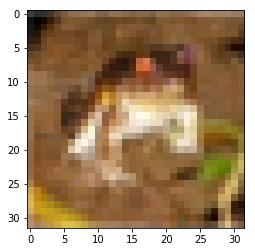

In [66]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(our_train_dataset.train_data[0])

In [67]:
our_train_dataset.train_labels[0]

6

### Task 2

Next we want to train the network by minimizing the `CrossEntropyLoss` for `50` epochs using the `SGD` and `Adam` optimizer using their default parameters and plot the validation accuracy and test accuracy over the course of the training.

In [74]:
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
train_loader = torch.utils.data.DataLoader(our_train_dataset,
                                           batch_size=128, 
                                           shuffle=True,
                                           **kwargs)
test_loader = torch.utils.data.DataLoader(our_test_dataset,
                                          batch_size=128,
                                          shuffle=False,
                                          **kwargs)

In [89]:
def train(epoch, opti, model):
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        opti.zero_grad()
        
        output = model(data)
        
        loss = F.cross_entropy(output, target)
        loss.backward()
        
        opti.step()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

In [90]:
def test(model):
    model.eval()
    
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return correct/ float(len(test_loader.dataset)), test_loss

In [86]:
### train network with SGD optimizer
model = VGG11()
if torch.cuda.is_available():
    model.cuda()
optimizer_SGD = optim.SGD(model.parameters(), lr=0.01)
for epoch in range(1, 3 + 1):
    train(epoch, optimizer_SGD, model)
    _ = test(model)


Train Epoch: 1 [0/50000 (0%)]	Loss: 2.327446
Train Epoch: 1 [1280/50000 (3%)]	Loss: 1.921564
Train Epoch: 1 [2560/50000 (5%)]	Loss: 1.773139
Train Epoch: 1 [3840/50000 (8%)]	Loss: 1.584186
Train Epoch: 1 [5120/50000 (10%)]	Loss: 1.565188
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.484501
Train Epoch: 1 [7680/50000 (15%)]	Loss: 1.597994
Train Epoch: 1 [8960/50000 (18%)]	Loss: 1.332569
Train Epoch: 1 [10240/50000 (20%)]	Loss: 1.312972
Train Epoch: 1 [11520/50000 (23%)]	Loss: 1.265416
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.356310
Train Epoch: 1 [14080/50000 (28%)]	Loss: 1.382148
Train Epoch: 1 [15360/50000 (31%)]	Loss: 1.434426
Train Epoch: 1 [16640/50000 (33%)]	Loss: 1.283121
Train Epoch: 1 [17920/50000 (36%)]	Loss: 1.173827
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.135102
Train Epoch: 1 [20480/50000 (41%)]	Loss: 1.249305
Train Epoch: 1 [21760/50000 (43%)]	Loss: 1.274621
Train Epoch: 1 [23040/50000 (46%)]	Loss: 1.187050
Train Epoch: 1 [24320/50000 (49%)]	Loss: 1.170210
Train Epoch: 1 

In [91]:
### train network with Adam optimizer
model = VGG11()
if torch.cuda.is_available():
    model.cuda()
optimizer_Adam = optim.Adam(model.parameters())
for epoch in range(1, 3 + 1):
    train(epoch, optimizer_Adam, model)
    _ = test(model)


Train Epoch: 1 [0/50000 (0%)]	Loss: 2.362432
Train Epoch: 1 [1280/50000 (3%)]	Loss: 1.975420
Train Epoch: 1 [2560/50000 (5%)]	Loss: 1.694353
Train Epoch: 1 [3840/50000 (8%)]	Loss: 1.762026
Train Epoch: 1 [5120/50000 (10%)]	Loss: 1.764282
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.495867
Train Epoch: 1 [7680/50000 (15%)]	Loss: 1.555777
Train Epoch: 1 [8960/50000 (18%)]	Loss: 1.253298
Train Epoch: 1 [10240/50000 (20%)]	Loss: 1.563218
Train Epoch: 1 [11520/50000 (23%)]	Loss: 1.447057
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.455868
Train Epoch: 1 [14080/50000 (28%)]	Loss: 1.669147
Train Epoch: 1 [15360/50000 (31%)]	Loss: 1.208204
Train Epoch: 1 [16640/50000 (33%)]	Loss: 1.148583
Train Epoch: 1 [17920/50000 (36%)]	Loss: 1.428475
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.334628
Train Epoch: 1 [20480/50000 (41%)]	Loss: 1.274751
Train Epoch: 1 [21760/50000 (43%)]	Loss: 1.323422
Train Epoch: 1 [23040/50000 (46%)]	Loss: 1.263938
Train Epoch: 1 [24320/50000 (49%)]	Loss: 1.161375
Train Epoch: 1 

### Task 3

Now implement decaying the learning rate using the `ReduceLROnPlateau` scheme in your training with $\delta=0.9$ and plot the validation and test accuracy over the course of the training using the `SGD` and `Adam` optimizer. You will need to lookup the PyTorch API to figure out how to use this scheme.

In [92]:
### train network with ReduceLROnPlateau scheme and SGD optimizer
model = VGG11()
if torch.cuda.is_available():
    model.cuda()
optimizer_SGD = optim.SGD(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_SGD, mode='min', factor=0.9, patience=3)
        
acc_list_SGD = []
for epoch in range(20 + 1):
    train(epoch, optimizer_SGD, model)
    acc, test_loss = test(model)
    acc_list_SGD += [ acc ]
    scheduler.step(test_loss)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.346887
Train Epoch: 0 [1280/50000 (3%)]	Loss: 1.756240
Train Epoch: 0 [2560/50000 (5%)]	Loss: 1.635840
Train Epoch: 0 [3840/50000 (8%)]	Loss: 1.566177
Train Epoch: 0 [5120/50000 (10%)]	Loss: 1.438602
Train Epoch: 0 [6400/50000 (13%)]	Loss: 1.330670
Train Epoch: 0 [7680/50000 (15%)]	Loss: 1.392710
Train Epoch: 0 [8960/50000 (18%)]	Loss: 1.366945
Train Epoch: 0 [10240/50000 (20%)]	Loss: 1.479705
Train Epoch: 0 [11520/50000 (23%)]	Loss: 1.376431
Train Epoch: 0 [12800/50000 (26%)]	Loss: 1.285922
Train Epoch: 0 [14080/50000 (28%)]	Loss: 1.345380
Train Epoch: 0 [15360/50000 (31%)]	Loss: 1.189955
Train Epoch: 0 [16640/50000 (33%)]	Loss: 1.157803
Train Epoch: 0 [17920/50000 (36%)]	Loss: 1.262439
Train Epoch: 0 [19200/50000 (38%)]	Loss: 1.281332
Train Epoch: 0 [20480/50000 (41%)]	Loss: 1.071644
Train Epoch: 0 [21760/50000 (43%)]	Loss: 1.025161
Train Epoch: 0 [23040/50000 (46%)]	Loss: 1.171392
Train Epoch: 0 [24320/50000 (49%)]	Loss: 1.029278
Train Epoch: 0 

Train Epoch: 4 [1280/50000 (3%)]	Loss: 0.377309
Train Epoch: 4 [2560/50000 (5%)]	Loss: 0.340462
Train Epoch: 4 [3840/50000 (8%)]	Loss: 0.269436
Train Epoch: 4 [5120/50000 (10%)]	Loss: 0.298207
Train Epoch: 4 [6400/50000 (13%)]	Loss: 0.309174
Train Epoch: 4 [7680/50000 (15%)]	Loss: 0.256862
Train Epoch: 4 [8960/50000 (18%)]	Loss: 0.360981
Train Epoch: 4 [10240/50000 (20%)]	Loss: 0.268393
Train Epoch: 4 [11520/50000 (23%)]	Loss: 0.275290
Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.270846
Train Epoch: 4 [14080/50000 (28%)]	Loss: 0.394625
Train Epoch: 4 [15360/50000 (31%)]	Loss: 0.334643
Train Epoch: 4 [16640/50000 (33%)]	Loss: 0.261869
Train Epoch: 4 [17920/50000 (36%)]	Loss: 0.305255
Train Epoch: 4 [19200/50000 (38%)]	Loss: 0.217311
Train Epoch: 4 [20480/50000 (41%)]	Loss: 0.311475
Train Epoch: 4 [21760/50000 (43%)]	Loss: 0.284187
Train Epoch: 4 [23040/50000 (46%)]	Loss: 0.376950
Train Epoch: 4 [24320/50000 (49%)]	Loss: 0.334467
Train Epoch: 4 [25600/50000 (51%)]	Loss: 0.279963
Train Epoc

Train Epoch: 8 [2560/50000 (5%)]	Loss: 0.020099
Train Epoch: 8 [3840/50000 (8%)]	Loss: 0.034434
Train Epoch: 8 [5120/50000 (10%)]	Loss: 0.043771
Train Epoch: 8 [6400/50000 (13%)]	Loss: 0.014061
Train Epoch: 8 [7680/50000 (15%)]	Loss: 0.008795
Train Epoch: 8 [8960/50000 (18%)]	Loss: 0.018979
Train Epoch: 8 [10240/50000 (20%)]	Loss: 0.016522
Train Epoch: 8 [11520/50000 (23%)]	Loss: 0.010974
Train Epoch: 8 [12800/50000 (26%)]	Loss: 0.018401
Train Epoch: 8 [14080/50000 (28%)]	Loss: 0.018665
Train Epoch: 8 [15360/50000 (31%)]	Loss: 0.015109
Train Epoch: 8 [16640/50000 (33%)]	Loss: 0.014918
Train Epoch: 8 [17920/50000 (36%)]	Loss: 0.016249
Train Epoch: 8 [19200/50000 (38%)]	Loss: 0.011049
Train Epoch: 8 [20480/50000 (41%)]	Loss: 0.014394
Train Epoch: 8 [21760/50000 (43%)]	Loss: 0.009619
Train Epoch: 8 [23040/50000 (46%)]	Loss: 0.010928
Train Epoch: 8 [24320/50000 (49%)]	Loss: 0.010787
Train Epoch: 8 [25600/50000 (51%)]	Loss: 0.014559
Train Epoch: 8 [26880/50000 (54%)]	Loss: 0.032395
Train Ep

Train Epoch: 12 [1280/50000 (3%)]	Loss: 0.001844
Train Epoch: 12 [2560/50000 (5%)]	Loss: 0.002872
Train Epoch: 12 [3840/50000 (8%)]	Loss: 0.003108
Train Epoch: 12 [5120/50000 (10%)]	Loss: 0.001870
Train Epoch: 12 [6400/50000 (13%)]	Loss: 0.001001
Train Epoch: 12 [7680/50000 (15%)]	Loss: 0.001879
Train Epoch: 12 [8960/50000 (18%)]	Loss: 0.001973
Train Epoch: 12 [10240/50000 (20%)]	Loss: 0.001560
Train Epoch: 12 [11520/50000 (23%)]	Loss: 0.001751
Train Epoch: 12 [12800/50000 (26%)]	Loss: 0.001201
Train Epoch: 12 [14080/50000 (28%)]	Loss: 0.001580
Train Epoch: 12 [15360/50000 (31%)]	Loss: 0.001995
Train Epoch: 12 [16640/50000 (33%)]	Loss: 0.001479
Train Epoch: 12 [17920/50000 (36%)]	Loss: 0.001639
Train Epoch: 12 [19200/50000 (38%)]	Loss: 0.001291
Train Epoch: 12 [20480/50000 (41%)]	Loss: 0.002930
Train Epoch: 12 [21760/50000 (43%)]	Loss: 0.001258
Train Epoch: 12 [23040/50000 (46%)]	Loss: 0.001352
Train Epoch: 12 [24320/50000 (49%)]	Loss: 0.002519
Train Epoch: 12 [25600/50000 (51%)]	Loss:


Test set: Average loss: 0.8279, Accuracy: 7930/10000 (79%)

Train Epoch: 16 [0/50000 (0%)]	Loss: 0.001397
Train Epoch: 16 [1280/50000 (3%)]	Loss: 0.001062
Train Epoch: 16 [2560/50000 (5%)]	Loss: 0.000857
Train Epoch: 16 [3840/50000 (8%)]	Loss: 0.001316
Train Epoch: 16 [5120/50000 (10%)]	Loss: 0.001021
Train Epoch: 16 [6400/50000 (13%)]	Loss: 0.001121
Train Epoch: 16 [7680/50000 (15%)]	Loss: 0.000812
Train Epoch: 16 [8960/50000 (18%)]	Loss: 0.001530
Train Epoch: 16 [10240/50000 (20%)]	Loss: 0.001118
Train Epoch: 16 [11520/50000 (23%)]	Loss: 0.000916
Train Epoch: 16 [12800/50000 (26%)]	Loss: 0.000906
Train Epoch: 16 [14080/50000 (28%)]	Loss: 0.001093
Train Epoch: 16 [15360/50000 (31%)]	Loss: 0.001097
Train Epoch: 16 [16640/50000 (33%)]	Loss: 0.000920
Train Epoch: 16 [17920/50000 (36%)]	Loss: 0.000946
Train Epoch: 16 [19200/50000 (38%)]	Loss: 0.000789
Train Epoch: 16 [20480/50000 (41%)]	Loss: 0.000813
Train Epoch: 16 [21760/50000 (43%)]	Loss: 0.000989
Train Epoch: 16 [23040/50000 (46%)]	

Train Epoch: 19 [47360/50000 (95%)]	Loss: 0.000869
Train Epoch: 19 [48640/50000 (97%)]	Loss: 0.001052
Train Epoch: 19 [31200/50000 (100%)]	Loss: 0.001189

Test set: Average loss: 0.8439, Accuracy: 7921/10000 (79%)

Train Epoch: 20 [0/50000 (0%)]	Loss: 0.000829
Train Epoch: 20 [1280/50000 (3%)]	Loss: 0.001221
Train Epoch: 20 [2560/50000 (5%)]	Loss: 0.000972
Train Epoch: 20 [3840/50000 (8%)]	Loss: 0.000619
Train Epoch: 20 [5120/50000 (10%)]	Loss: 0.000976
Train Epoch: 20 [6400/50000 (13%)]	Loss: 0.001437
Train Epoch: 20 [7680/50000 (15%)]	Loss: 0.000705
Train Epoch: 20 [8960/50000 (18%)]	Loss: 0.000750
Train Epoch: 20 [10240/50000 (20%)]	Loss: 0.000774
Train Epoch: 20 [11520/50000 (23%)]	Loss: 0.001147
Train Epoch: 20 [12800/50000 (26%)]	Loss: 0.000837
Train Epoch: 20 [14080/50000 (28%)]	Loss: 0.000550
Train Epoch: 20 [15360/50000 (31%)]	Loss: 0.000720
Train Epoch: 20 [16640/50000 (33%)]	Loss: 0.000580
Train Epoch: 20 [17920/50000 (36%)]	Loss: 0.001113
Train Epoch: 20 [19200/50000 (38%)]

Text(0,0.5,'Accuracy')

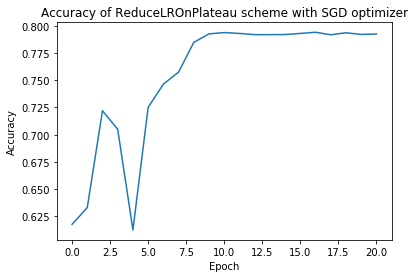

In [93]:
plt.plot(acc_list_SGD)
plt.title('Accuracy of ReduceLROnPlateau scheme with SGD optimizer')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [94]:
### train network with ReduceLROnPlateau scheme and Adam optimizer
model = VGG11()
if torch.cuda.is_available():
    model.cuda()
optimizer_Adam = optim.Adam(model.parameters(), lr=0.01)
optimizer_Adam_ReduceLROnPlateau = optim.lr_scheduler.ReduceLROnPlateau(optimizer_Adam, mode='min', factor=0.9, patience=3)
        
acc_list_Adam = []
for epoch in range(20 + 1):
    train(epoch, optimizer_Adam, model)
    acc, test_loss = test(model)
    acc_list_Adam += [ acc ]
    scheduler.step(test_loss)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.387114
Train Epoch: 0 [1280/50000 (3%)]	Loss: 2.644073
Train Epoch: 0 [2560/50000 (5%)]	Loss: 2.417340
Train Epoch: 0 [3840/50000 (8%)]	Loss: 2.242964
Train Epoch: 0 [5120/50000 (10%)]	Loss: 2.325171
Train Epoch: 0 [6400/50000 (13%)]	Loss: 2.197703
Train Epoch: 0 [7680/50000 (15%)]	Loss: 2.249962
Train Epoch: 0 [8960/50000 (18%)]	Loss: 2.080677
Train Epoch: 0 [10240/50000 (20%)]	Loss: 2.152699
Train Epoch: 0 [11520/50000 (23%)]	Loss: 2.040964
Train Epoch: 0 [12800/50000 (26%)]	Loss: 1.934500
Train Epoch: 0 [14080/50000 (28%)]	Loss: 1.932179
Train Epoch: 0 [15360/50000 (31%)]	Loss: 2.096036
Train Epoch: 0 [16640/50000 (33%)]	Loss: 1.931665
Train Epoch: 0 [17920/50000 (36%)]	Loss: 1.954759
Train Epoch: 0 [19200/50000 (38%)]	Loss: 1.752962
Train Epoch: 0 [20480/50000 (41%)]	Loss: 1.795695
Train Epoch: 0 [21760/50000 (43%)]	Loss: 1.629164
Train Epoch: 0 [23040/50000 (46%)]	Loss: 1.864173
Train Epoch: 0 [24320/50000 (49%)]	Loss: 1.703882
Train Epoch: 0 

Train Epoch: 4 [1280/50000 (3%)]	Loss: 0.533015
Train Epoch: 4 [2560/50000 (5%)]	Loss: 0.438418
Train Epoch: 4 [3840/50000 (8%)]	Loss: 0.643440
Train Epoch: 4 [5120/50000 (10%)]	Loss: 0.458291
Train Epoch: 4 [6400/50000 (13%)]	Loss: 0.592778
Train Epoch: 4 [7680/50000 (15%)]	Loss: 0.551846
Train Epoch: 4 [8960/50000 (18%)]	Loss: 0.478516
Train Epoch: 4 [10240/50000 (20%)]	Loss: 0.468707
Train Epoch: 4 [11520/50000 (23%)]	Loss: 0.521586
Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.477571
Train Epoch: 4 [14080/50000 (28%)]	Loss: 0.690977
Train Epoch: 4 [15360/50000 (31%)]	Loss: 0.553026
Train Epoch: 4 [16640/50000 (33%)]	Loss: 0.516857
Train Epoch: 4 [17920/50000 (36%)]	Loss: 0.607211
Train Epoch: 4 [19200/50000 (38%)]	Loss: 0.459952
Train Epoch: 4 [20480/50000 (41%)]	Loss: 0.743469
Train Epoch: 4 [21760/50000 (43%)]	Loss: 0.531121
Train Epoch: 4 [23040/50000 (46%)]	Loss: 0.521312
Train Epoch: 4 [24320/50000 (49%)]	Loss: 0.477684
Train Epoch: 4 [25600/50000 (51%)]	Loss: 0.480961
Train Epoc

Train Epoch: 8 [2560/50000 (5%)]	Loss: 0.200365
Train Epoch: 8 [3840/50000 (8%)]	Loss: 0.168476
Train Epoch: 8 [5120/50000 (10%)]	Loss: 0.243468
Train Epoch: 8 [6400/50000 (13%)]	Loss: 0.124141
Train Epoch: 8 [7680/50000 (15%)]	Loss: 0.139167
Train Epoch: 8 [8960/50000 (18%)]	Loss: 0.165799
Train Epoch: 8 [10240/50000 (20%)]	Loss: 0.159253
Train Epoch: 8 [11520/50000 (23%)]	Loss: 0.227144
Train Epoch: 8 [12800/50000 (26%)]	Loss: 0.194721
Train Epoch: 8 [14080/50000 (28%)]	Loss: 0.139423
Train Epoch: 8 [15360/50000 (31%)]	Loss: 0.185377
Train Epoch: 8 [16640/50000 (33%)]	Loss: 0.271354
Train Epoch: 8 [17920/50000 (36%)]	Loss: 0.151043
Train Epoch: 8 [19200/50000 (38%)]	Loss: 0.218894
Train Epoch: 8 [20480/50000 (41%)]	Loss: 0.212699
Train Epoch: 8 [21760/50000 (43%)]	Loss: 0.242149
Train Epoch: 8 [23040/50000 (46%)]	Loss: 0.194014
Train Epoch: 8 [24320/50000 (49%)]	Loss: 0.199243
Train Epoch: 8 [25600/50000 (51%)]	Loss: 0.235125
Train Epoch: 8 [26880/50000 (54%)]	Loss: 0.175554
Train Ep

Train Epoch: 12 [1280/50000 (3%)]	Loss: 0.073991
Train Epoch: 12 [2560/50000 (5%)]	Loss: 0.054042
Train Epoch: 12 [3840/50000 (8%)]	Loss: 0.062846
Train Epoch: 12 [5120/50000 (10%)]	Loss: 0.130956
Train Epoch: 12 [6400/50000 (13%)]	Loss: 0.099665
Train Epoch: 12 [7680/50000 (15%)]	Loss: 0.092284
Train Epoch: 12 [8960/50000 (18%)]	Loss: 0.108335
Train Epoch: 12 [10240/50000 (20%)]	Loss: 0.104850
Train Epoch: 12 [11520/50000 (23%)]	Loss: 0.020269
Train Epoch: 12 [12800/50000 (26%)]	Loss: 0.088761
Train Epoch: 12 [14080/50000 (28%)]	Loss: 0.087444
Train Epoch: 12 [15360/50000 (31%)]	Loss: 0.126289
Train Epoch: 12 [16640/50000 (33%)]	Loss: 0.056411
Train Epoch: 12 [17920/50000 (36%)]	Loss: 0.073253
Train Epoch: 12 [19200/50000 (38%)]	Loss: 0.081266
Train Epoch: 12 [20480/50000 (41%)]	Loss: 0.184408
Train Epoch: 12 [21760/50000 (43%)]	Loss: 0.197595
Train Epoch: 12 [23040/50000 (46%)]	Loss: 0.089648
Train Epoch: 12 [24320/50000 (49%)]	Loss: 0.109774
Train Epoch: 12 [25600/50000 (51%)]	Loss:


Test set: Average loss: 0.9054, Accuracy: 8059/10000 (81%)

Train Epoch: 16 [0/50000 (0%)]	Loss: 0.031283
Train Epoch: 16 [1280/50000 (3%)]	Loss: 0.025985
Train Epoch: 16 [2560/50000 (5%)]	Loss: 0.042919
Train Epoch: 16 [3840/50000 (8%)]	Loss: 0.040100
Train Epoch: 16 [5120/50000 (10%)]	Loss: 0.032890
Train Epoch: 16 [6400/50000 (13%)]	Loss: 0.057284
Train Epoch: 16 [7680/50000 (15%)]	Loss: 0.014542
Train Epoch: 16 [8960/50000 (18%)]	Loss: 0.051372
Train Epoch: 16 [10240/50000 (20%)]	Loss: 0.031257
Train Epoch: 16 [11520/50000 (23%)]	Loss: 0.038268
Train Epoch: 16 [12800/50000 (26%)]	Loss: 0.081653
Train Epoch: 16 [14080/50000 (28%)]	Loss: 0.059073
Train Epoch: 16 [15360/50000 (31%)]	Loss: 0.087872
Train Epoch: 16 [16640/50000 (33%)]	Loss: 0.061585
Train Epoch: 16 [17920/50000 (36%)]	Loss: 0.050340
Train Epoch: 16 [19200/50000 (38%)]	Loss: 0.045261
Train Epoch: 16 [20480/50000 (41%)]	Loss: 0.025261
Train Epoch: 16 [21760/50000 (43%)]	Loss: 0.058661
Train Epoch: 16 [23040/50000 (46%)]	

Train Epoch: 19 [47360/50000 (95%)]	Loss: 0.038907
Train Epoch: 19 [48640/50000 (97%)]	Loss: 0.031434
Train Epoch: 19 [31200/50000 (100%)]	Loss: 0.069160

Test set: Average loss: 0.9114, Accuracy: 8057/10000 (81%)

Train Epoch: 20 [0/50000 (0%)]	Loss: 0.018665
Train Epoch: 20 [1280/50000 (3%)]	Loss: 0.054536
Train Epoch: 20 [2560/50000 (5%)]	Loss: 0.016982
Train Epoch: 20 [3840/50000 (8%)]	Loss: 0.012501
Train Epoch: 20 [5120/50000 (10%)]	Loss: 0.045178
Train Epoch: 20 [6400/50000 (13%)]	Loss: 0.018363
Train Epoch: 20 [7680/50000 (15%)]	Loss: 0.015299
Train Epoch: 20 [8960/50000 (18%)]	Loss: 0.003931
Train Epoch: 20 [10240/50000 (20%)]	Loss: 0.025374
Train Epoch: 20 [11520/50000 (23%)]	Loss: 0.008007
Train Epoch: 20 [12800/50000 (26%)]	Loss: 0.048422
Train Epoch: 20 [14080/50000 (28%)]	Loss: 0.008258
Train Epoch: 20 [15360/50000 (31%)]	Loss: 0.008027
Train Epoch: 20 [16640/50000 (33%)]	Loss: 0.011864
Train Epoch: 20 [17920/50000 (36%)]	Loss: 0.013793
Train Epoch: 20 [19200/50000 (38%)]

Text(0,0.5,'Accuracy')

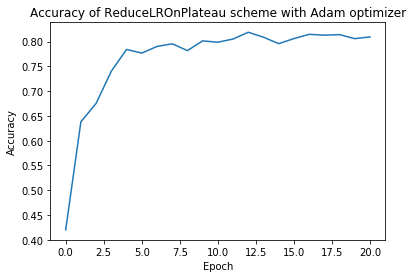

In [95]:
plt.plot(acc_list_Adam)
plt.title('Accuracy of ReduceLROnPlateau scheme with Adam optimizer')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

### Task 4

Finally we want to tune the initial step size or  learning rate for the `SGD` and `Adam` for the setup we have till now. 

One strategy is to distribute different learning rates between your fellow classmates and then communicate the best result and refine the learning rate this way till you collectively find the best parameter. This will require some coordination and communication which is what I actually want you do to. Some of your classmates will be confused or stuck, help them! Perhaps you will see some neat helper or good code abstraction, learn from it and apply it to your own code.

Finally, plot the validation accuracy and test accuracy over the course of training for the best learning rate you found for both `SGD` and `Adam`.

In [ ]:
### YOUR CODE HERE ###